# Crypto Currency Cross-Prediction 01 (without restore_best_weights)

## 2024-01-01 ~ 2024-10-31

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from util import *
from nbeat import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Define the date range
# start_date = datetime(2023, 1, 1)  # Start date in milliseconds
# end_date = datetime(2023, 11, 1)    # End date in milliseconds (exclusive)# Fetch historical data
# bnb_data = fetchHistoricalData('BNBUSDT', start_date, end_date)
# read csv file
# use fetch-historical-data.py to fetch data
bnb_data = pd.read_csv('data/BNBUSDT_1D.csv')

if bnb_data is not None:
    print(bnb_data)

      Open Time    Open    High     Low   Close      volume
0    2022-01-01  511.55  528.16  511.43  527.34   603346.10
1    2022-01-02  527.36  533.90  518.01  530.91   572079.85
2    2022-01-03  530.92  533.00  510.41  512.24   795766.94
3    2022-01-04  512.24  519.85  502.00  506.88  1042411.20
4    2022-01-05  506.88  515.92  456.20  473.95  1450747.64
..          ...     ...     ...     ...     ...         ...
725  2023-12-27  297.50  324.13  285.00  323.76  3928291.07
726  2023-12-28  323.75  337.73  319.20  322.21  4582442.88
727  2023-12-29  322.20  325.25  306.46  313.29  2408793.98
728  2023-12-30  313.29  320.48  311.84  316.71  1141399.89
729  2023-12-31  316.69  324.79  306.38  311.33  1294462.46

[730 rows x 6 columns]


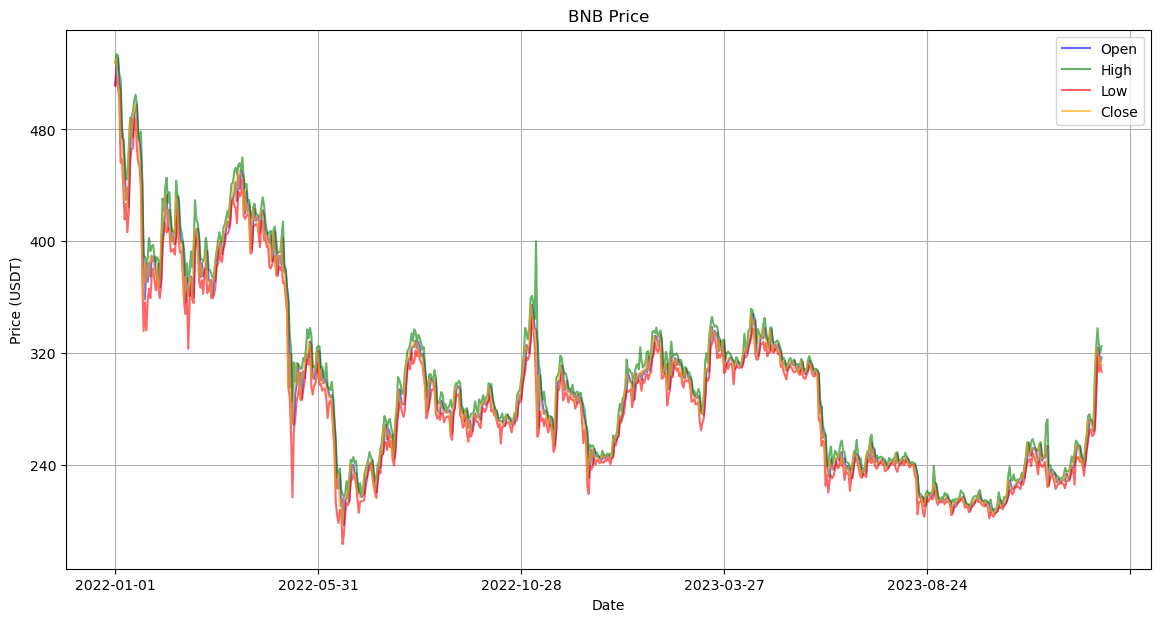

In [4]:
plotPriceDatas(bnb_data, 'BNB Price')

In [5]:
# Fetch historical data
# btc_data = fetchHistoricalData('BTCUSDT', start_date, end_date)
btc_data = pd.read_csv('data/BTCUSDT_1D.csv')

      Open Time      Open      High       Low     Close      volume
0    2022-01-01  46210.57  47943.77  46210.55  47704.35  179433.584
1    2022-01-02  47704.35  48000.00  46605.68  47280.00  184795.093
2    2022-01-03  47280.01  47575.22  45665.40  46445.81  244781.793
3    2022-01-04  46445.80  47524.36  45445.57  45833.42  292149.750
4    2022-01-05  45833.41  47075.29  42270.00  43421.69  485477.569
..          ...       ...       ...       ...       ...         ...
725  2023-12-27  42538.60  43700.00  42145.70  43453.80  251351.538
726  2023-12-28  43453.80  43850.00  42320.50  42600.10  257515.182
727  2023-12-29  42600.10  43171.90  41283.20  42095.10  337421.865
728  2023-12-30  42095.10  42654.60  41550.00  42174.20  183890.670
729  2023-12-31  42174.30  42951.00  42001.00  42314.00  173508.289

[730 rows x 6 columns]


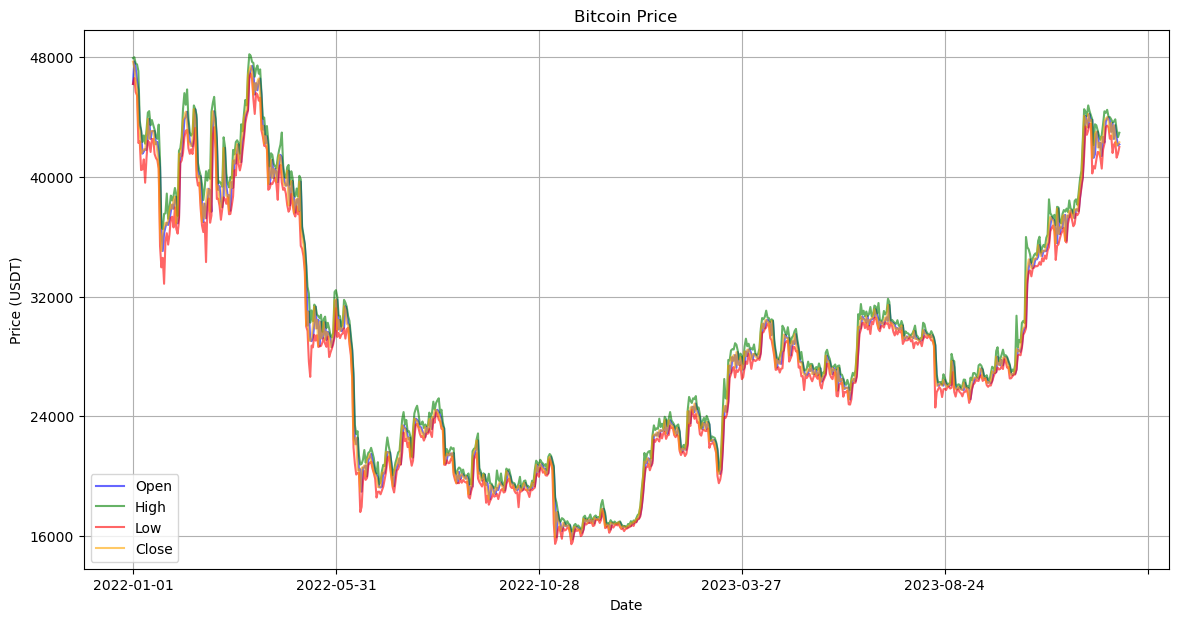

In [6]:
if btc_data is not None:
    print(btc_data)

plotPriceDatas(btc_data, 'Bitcoin Price')

In [7]:
dataSize = len(btc_data)
assert(dataSize == len(bnb_data))
windowSize = 35
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 730
windowSize: 35
testSize: 219


In [8]:
testingOutput = prepareTestingOutputs(bnb_data["Close"], testSize)
print(testingOutput)

[307.55 314.36 311.98 311.54 306.9  305.12 307.39 306.73 305.23 277.
 281.18 259.22 261.96 260.78 238.74 235.19 231.23 243.92 237.78 236.33
 239.17 244.44 244.01 243.02 247.93 248.94 240.91 244.53 236.33 238.97
 236.15 237.45 230.52 233.12 240.45 247.99 246.77 246.62 242.53 238.85
 231.92 235.43 236.13 233.91 245.97 248.34 243.7  255.99 247.89 250.79
 241.91 244.03 240.48 241.05 242.93 243.88 241.23 242.54 239.02 237.86
 239.05 240.88 241.93 242.64 242.72 241.04 247.87 240.64 241.01 241.73
 243.34 243.26 241.96 245.24 243.9  241.33 239.76 240.18 239.92 240.35
 236.73 231.96 217.89 215.97 216.8  216.41 210.22 210.84 216.53 219.06
 218.36 216.34 218.35 218.75 226.87 223.83 216.58 213.65 214.33 214.35
 215.19 214.51 215.22 217.11 214.62 214.2  212.28 206.08 210.73 212.63
 212.04 214.   214.74 216.31 215.99 217.22 214.39 210.91 211.15 210.52
 208.34 210.06 212.68 212.15 215.06 215.21 214.69 218.29 214.7  213.46
 213.45 210.8  213.42 212.33 211.42 205.83 208.59 206.61 205.29 206.05
 206.6  

### Brenchmarking with "trivial prediction"

Trivial prediction is a simple model that predict the next date value as the current one.

[306.81 307.55 314.36 311.98 311.54 306.9  305.12 307.39 306.73 305.23
 277.   281.18 259.22 261.96 260.78 238.74 235.19 231.23 243.92 237.78
 236.33 239.17 244.44 244.01 243.02 247.93 248.94 240.91 244.53 236.33
 238.97 236.15 237.45 230.52 233.12 240.45 247.99 246.77 246.62 242.53
 238.85 231.92 235.43 236.13 233.91 245.97 248.34 243.7  255.99 247.89
 250.79 241.91 244.03 240.48 241.05 242.93 243.88 241.23 242.54 239.02
 237.86 239.05 240.88 241.93 242.64 242.72 241.04 247.87 240.64 241.01
 241.73 243.34 243.26 241.96 245.24 243.9  241.33 239.76 240.18 239.92
 240.35 236.73 231.96 217.89 215.97 216.8  216.41 210.22 210.84 216.53
 219.06 218.36 216.34 218.35 218.75 226.87 223.83 216.58 213.65 214.33
 214.35 215.19 214.51 215.22 217.11 214.62 214.2  212.28 206.08 210.73
 212.63 212.04 214.   214.74 216.31 215.99 217.22 214.39 210.91 211.15
 210.52 208.34 210.06 212.68 212.15 215.06 215.21 214.69 218.29 214.7
 213.46 213.45 210.8  213.42 212.33 211.42 205.83 208.59 206.61 205.29
 206.05

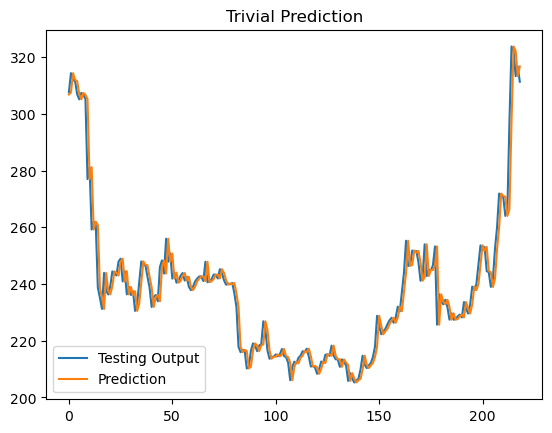

In [9]:
prediction0 = np.array(bnb_data["Close"][range(dataSize - testSize - 1, dataSize - 1)])
print(prediction0)
plt.plot(testingOutput, label="Testing Output")
plt.plot(prediction0, label="Prediction")
plt.title("Trivial Prediction")
plt.legend()

rmse0 = tf.keras.metrics.RootMeanSquaredError()(testingOutput, prediction0)
print(f"RootMeanSquaredError {rmse0}")

# calculate the correlation between the prediction and the actual values
corr0 = np.corrcoef(prediction0, testingOutput)[0, 1]
print(f"Correlation {corr0}")

### N-Beat Alogrithm
#### [Model1] BNB closing price -> BNB closing price

In [10]:
x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)
x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

In [11]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 35), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 35), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [12]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 35),         824868      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 35)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                              

In [13]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [14]:
history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=False),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 286: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


7/7 [==============================] - 2s 18ms/step - loss: 5.2294 - mae: 5.2294 - mse: 56.4218
rmse1: 7.51144476920066


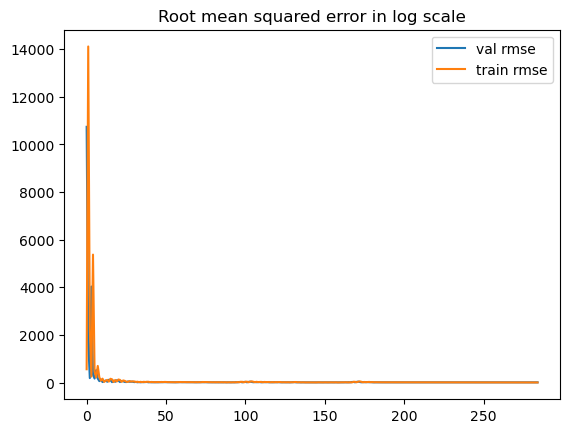

In [15]:
plotHistoryRSME(history1, 300)

rmse1 = np.sqrt(model1.evaluate(x_test, y_test)[2])
print(f"rmse1: {rmse1}")


In [16]:
# model1.save('models/model1-1')

corr: 0.955223043413924


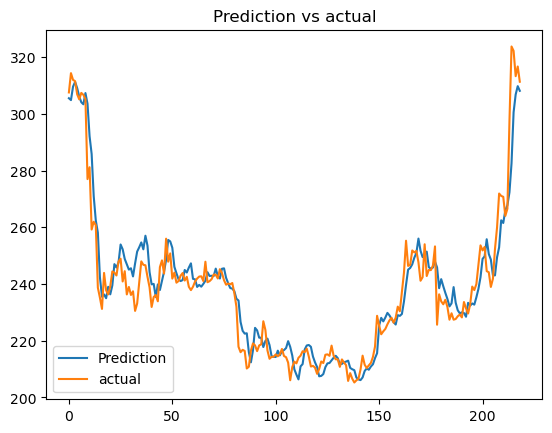

In [17]:
# plot prediction
prediction1 = model1.predict(x_test)
plt.plot(prediction1, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr1 = np.corrcoef(prediction1.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr1}")

In [20]:
# # x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize)
# x_train2 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# # y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# # x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# y_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize)
# x_test2 = [np.concatenate((x_test[i], y_test_btc[i])) for i in range(len(x_test))]
# # y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

# train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train2)
# train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
# test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test2)
# test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
# test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# train_dataset, test_dataset

#### [Model3] Fix
It's weird to have higher error with more data. Let's try normalize BTC price first.

In [22]:
print(f"x_train mean: {np.mean(x_train)}")
print(f"x_train_btc mean: {np.mean(x_train_btc)}")
np.mean(x_train_btc) / np.mean(x_train)

x_train mean: 315.0604633853542
x_train_btc mean: 26691.71292857143


84.7193349548416

BTC is about 90 times higher than BNB. Let's scale it down by 90.

In [23]:
BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train3 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test3 = [np.concatenate((x_test[i], x_test_btc[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train3)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test3)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model3 = tf.keras.Model(inputs=input, outputs=x)
# model3.summary()

model3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history3 = model3.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=False),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 113: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 213: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


7/7 [==============================] - 2s 22ms/step - loss: 45.4835 - mae: 45.4835 - mse: 3169.9155
rmse3: 56.30200287151204
corr: 0.6417740151036467


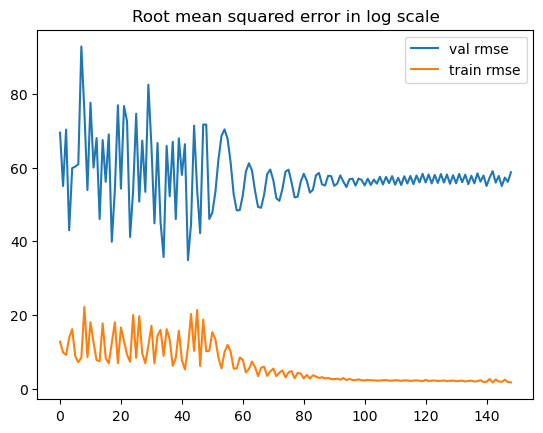

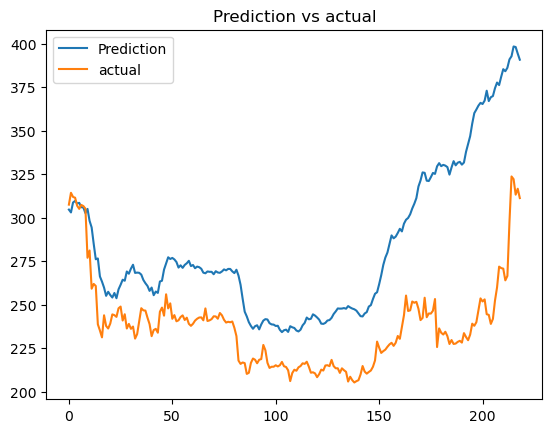

In [24]:
rmse3 = np.sqrt(model3.evaluate(np.array(x_test3), y_test)[2])
print(f"rmse3: {rmse3}")

plotHistoryRSME(history3)
plt.figure()

# plot prediction
prediction3 = model3.predict(np.array(x_test3))
plt.plot(prediction3, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr3 = np.corrcoef(prediction3.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr3}")

#### [Model4] Swap input position

Lets try putting BTC values before BNB values.

In [25]:
# BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

In [26]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model4 = tf.keras.Model(inputs=input, outputs=x)
# model4.summary()

model4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history4 = model4.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=False),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 270: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


7/7 [==============================] - 2s 22ms/step - loss: 35.0906 - mae: 35.0906 - mse: 1526.3181
rmse4: 39.06812147050809
corr: 0.7423980735420097


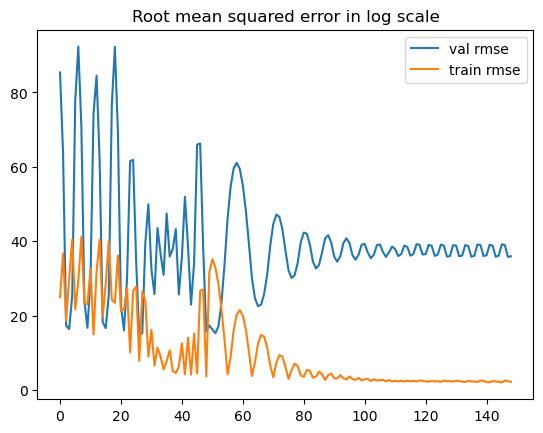

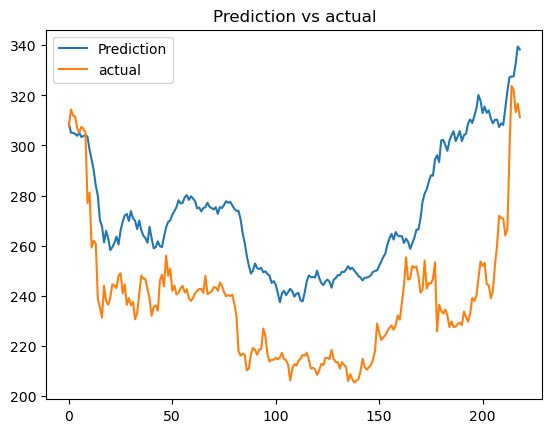

In [27]:
rmse4 = np.sqrt(model4.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse4: {rmse4}")

# plot error
plotHistoryRSME(history4)
plt.figure()

# plot prediction
prediction4 = model4.predict(np.array(x_test4))
plt.plot(prediction4, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr4 = np.corrcoef(prediction4.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr4}")

#### [Model5] Increase Neuron

It seems that BTC data would confuse the model, or it doesn't have enough unit to process the data. Let's try to increase the neuron number.

In [28]:
# BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

nbeatNeuronCount = round(512 * np.power(2, 0.5)) # the number of attributes should be increased by 2
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model5 = tf.keras.Model(inputs=input, outputs=x)
model5.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 70)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 70),         1677579     ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 70)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [29]:
model5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history5 = model5.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=False),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 207: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 307: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


7/7 [==============================] - 2s 25ms/step - loss: 39.5063 - mae: 39.5063 - mse: 2081.3154
rmse5: 45.62143607655835
corr: 0.6964528554966112


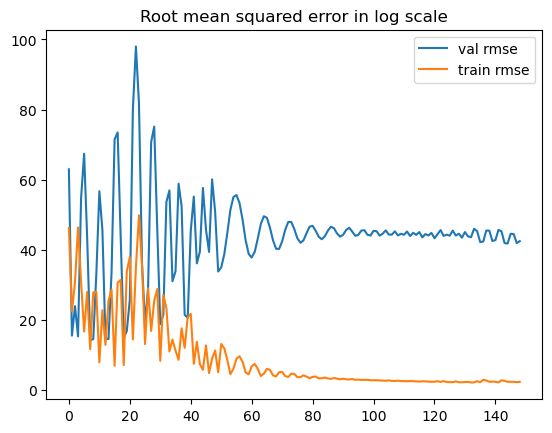

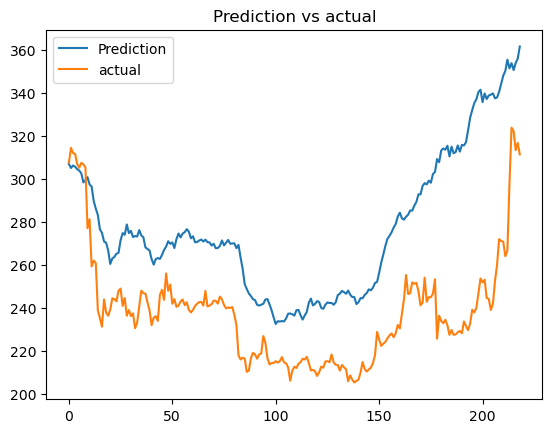

In [30]:
rmse5 = np.sqrt(model5.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse5: {rmse5}")

# plot error
plotHistoryRSME(history5)
plt.figure()

# plot prediction
prediction5 = model5.predict(np.array(x_test4))
plt.plot(prediction5, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

corr5 = np.corrcoef(prediction5.reshape(-1), y_test)[0, 1] 
print(f"corr: {corr5}")

#### Conclusion

The model with BTC data seems performs worse that without it. Lets try with more data and larger window size next time.

<BarContainer object of 5 artists>

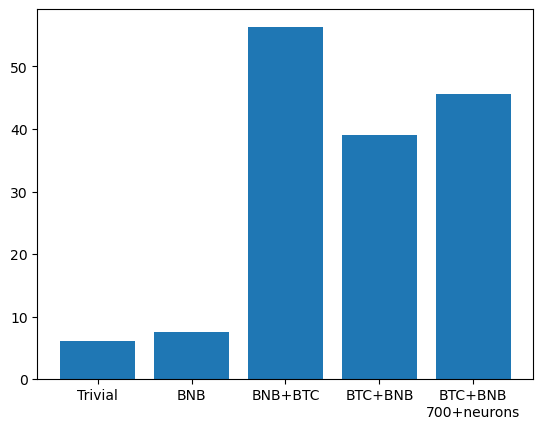

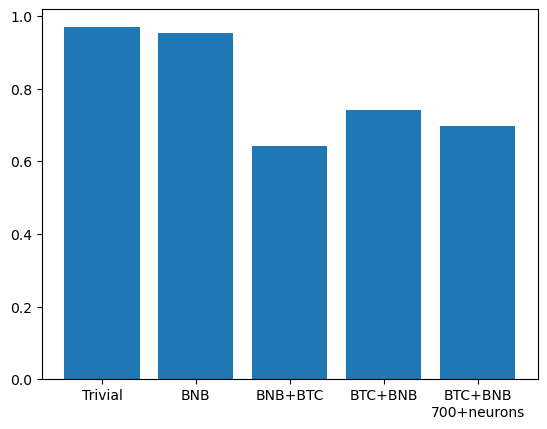

In [31]:
models = ["Trivial", "BNB", "BNB+BTC", "BTC+BNB", "BTC+BNB\n700+neurons"]
rmses = [rmse0, rmse1, rmse3, rmse4, rmse5]
plt.bar(models, rmses)

plt.figure()
corrs = [corr0, corr1, corr3, corr4, corr5]
plt.bar(models, corrs)